<a href="https://colab.research.google.com/github/israt-tabassum/AirQuality_Univariate/blob/main/TSSequencerPlus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 M

epoch,train_loss,valid_loss,mae,time
0,0.001620,0.000280,0.004140,10:26
1,0.001115,0.000334,0.008812,10:47
2,0.000417,0.000270,0.001245,10:38
3,0.000560,0.000273,0.002042,10:35
4,0.000107,0.000330,0.008482,10:27
5,0.000131,0.000275,0.003068,10:37
6,0.000107,0.000270,0.001699,10:39
7,0.000027,0.000269,0.000452,10:43
8,0.000456,0.000270,0.001000,10:40
9,0.000011,0.000270,0.001627,10:37


Validation MAE: 0.0016


Validation RMSE: 2460216.9533


Predicted next 10 values: [115744.41]


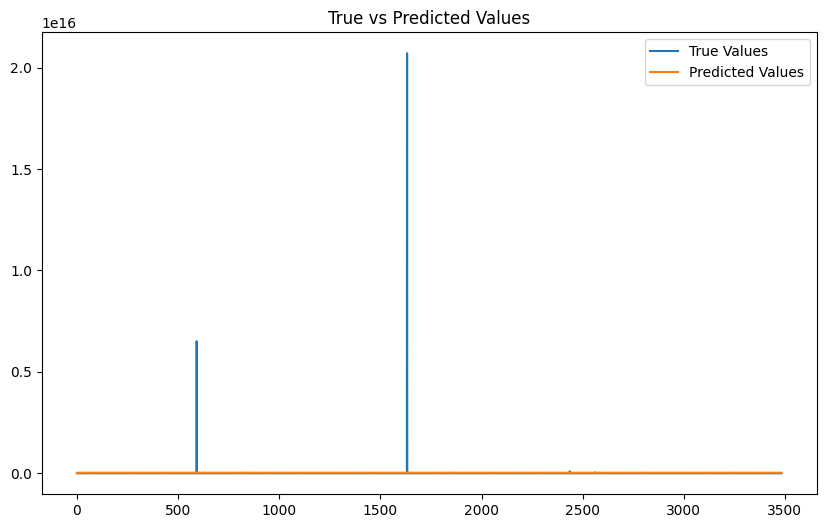

In [1]:
# Install necessary packages (uncomment if needed)
!pip install tsai
!pip install pandas scikit-learn numpy matplotlib

# Required Libraries
from tsai.all import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Load the data
df = pd.read_csv('/content/drive/MyDrive/AirQuality/tromso_PM2.5_hourly_e1_csv/tromso_PM2.5_hourly_e1.csv', parse_dates=['Start', 'End'])

# Filter and preprocess data
df = df[['Start', 'Value']].sort_values(by='Start')
scaler = MinMaxScaler()
df['Value'] = scaler.fit_transform(df[['Value']])

# Extract the values for modeling
values = df['Value'].values

# Create time series dataset using `tsai`'s SlidingWindow
sequence_length = 100  # Number of steps in each input sequence
X, y = SlidingWindow(window_len=sequence_length, horizon=1)(values)  # Corrected argument name

# Generate train-test split indices using `RandomSplitter`
splits = RandomSplitter(valid_pct=0.2)(range_of(X))  # Automatically create splits

# Convert to DataLoaders for tsai
tfms = [None, TSForecasting()]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=32)

# Define the TSSequencerPlus model
model = TSSequencerPlus(
    c_in=1,       # Number of input features
    c_out=1,      # Number of output features (forecast horizon)
    seq_len=sequence_length,
    d_model=128,  # Model dimension
    depth=6,      # Number of encoder layers
    lstm_dropout=0.1,
    dropout=0.1,
    drop_path_rate=0.1,
    use_token=False  # Adjust based on your task (classification vs forecasting)
)

# Create a Learner
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=mae)

# Train the model
learn.fit_one_cycle(10, lr_max=1e-3)

# Validate the model
valid_mae = learn.validate()[1]
print(f"Validation MAE: {valid_mae:.4f}")

# Evaluate RMSE on the validation set
preds, targs = learn.get_preds(ds_idx=1)
y_valid_pred = preds.numpy()
y_valid_true = targs.numpy()
y_valid_pred = scaler.inverse_transform(y_valid_pred)
y_valid_true = scaler.inverse_transform(y_valid_true.reshape(-1, 1))
rmse = sqrt(mean_squared_error(y_valid_true, y_valid_pred))
print(f"Validation RMSE: {rmse:.4f}")

# Predict future steps
future_steps = 10
last_seq = values[-sequence_length:].reshape(1, sequence_length)
preds = learn.get_X_preds(torch.tensor(last_seq).unsqueeze(1).float())[0]
preds = scaler.inverse_transform(preds.numpy())

print(f"Predicted next {future_steps} values: {preds.flatten()}")

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(y_valid_true), label='True Values')
plt.plot(scaler.inverse_transform(y_valid_pred), label='Predicted Values')
plt.legend()
plt.title("True vs Predicted Values")
plt.show()


epoch,train_loss,valid_loss,mae,time
0,0.001343,0.005923,0.057611,11:28
1,0.000790,0.002287,0.036118,10:29
2,0.000643,0.002006,0.034512,10:36
3,0.000302,0.002230,0.035118,10:28
4,0.000384,0.002936,0.042454,10:31


epoch,train_loss,valid_loss,mae,time
0,0.001343,0.005923,0.057611,11:28
1,0.000790,0.002287,0.036118,10:29
2,0.000643,0.002006,0.034512,10:36
3,0.000302,0.002230,0.035118,10:28
4,0.000384,0.002936,0.042454,10:31
5,0.000409,0.002184,0.034677,10:29
6,0.000269,0.001831,0.032751,10:30
7,0.000214,0.001603,0.030270,10:41
8,0.000201,0.001666,0.029607,10:39
9,0.000159,0.001681,0.029915,10:34


Predicted next 24 values: [  3583411.    -3080923.     4437389.     4301320.5     384767.53
  -2081467.4    9676431.     3295689.8   -7447222.      975729.94
  -2969336.8    2122876.8    2698930.8    1786377.4    3366560.8
   2043928.5    4861782.    -3871099.5  -13259410.     2952806.5
  -4325892.    -6816256.     8633419.     1178747.9 ]


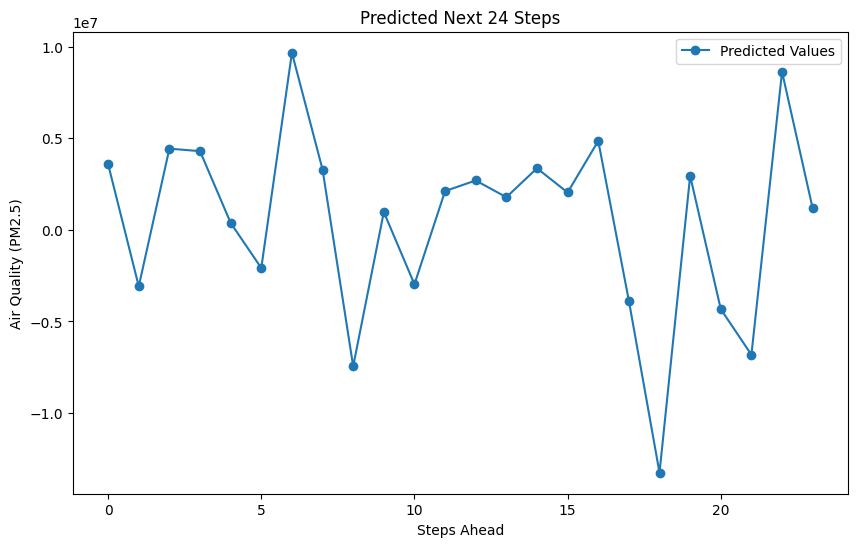

In [2]:
# Define the number of steps to predict
forecast_steps = 24  # Use 6 for 6-hour prediction

# Create time series dataset using `tsai`'s SlidingWindow
X, y = SlidingWindow(window_len=sequence_length, horizon=forecast_steps)(values)

# Generate train-test split indices using `RandomSplitter`
splits = RandomSplitter(valid_pct=0.2)(range_of(X))

# Convert to DataLoaders for tsai
tfms = [None, TSForecasting()]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=32)

# Update TSSequencerPlus model
model = TSSequencerPlus(
    c_in=1,       # Number of input features
    c_out=forecast_steps,  # Number of output features (forecast steps)
    seq_len=sequence_length,
    d_model=128,  # Model dimension
    depth=6,      # Number of encoder layers
    lstm_dropout=0.1,
    dropout=0.1,
    drop_path_rate=0.1,
    use_token=False
)

# Create a Learner
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=mae)

# Train the model
learn.fit_one_cycle(10, lr_max=1e-3)

# Predict future steps
last_seq = values[-sequence_length:].reshape(1, sequence_length)  # Last sequence as input
preds = learn.get_X_preds(torch.tensor(last_seq).unsqueeze(1).float())[0]  # Predict next steps
preds = scaler.inverse_transform(preds.numpy())  # Inverse transform to original scale

# Print predictions
print(f"Predicted next {forecast_steps} values: {preds.flatten()}")

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(preds.flatten(), label='Predicted Values', marker='o')
plt.title(f"Predicted Next {forecast_steps} Steps")
plt.xlabel("Steps Ahead")
plt.ylabel("Air Quality (PM2.5)")
plt.legend()
plt.show()
